Loaded: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\data\toy_data\metadata\toy_cell_spatial_features__LysosomeA_vs_LysosomeB.csv
Cells: 35
Groups: {'treated': 19, 'untreated': 16}
Tiles : 12
X shape: (35, 7)
y distribution: {np.int64(0): np.int64(16), np.int64(1): np.int64(19)}
Leakage check: set()
[Fold 1] acc=0.533  bacc=0.545  f1=0.588  auc=0.5982142857142857
[Fold 2] acc=0.692  bacc=0.600  f1=0.800  auc=0.6625000000000001
[Fold 3] acc=0.286  bacc=0.333  f1=0.000  auc=0.16666666666666669

CV metrics (mean ± sd):
          mean       std
acc   0.503785  0.204901
bacc  0.492659  0.140729
f1    0.462745  0.414501
auc   0.475794  0.269635


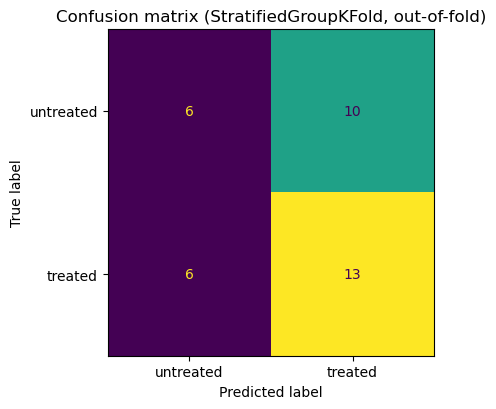

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\03_confusion_treated_vs_untreated.png


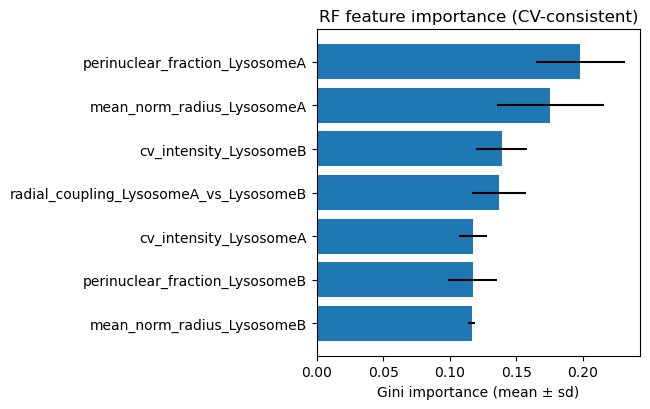

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\03_rf_importance_gini_cvmean.png


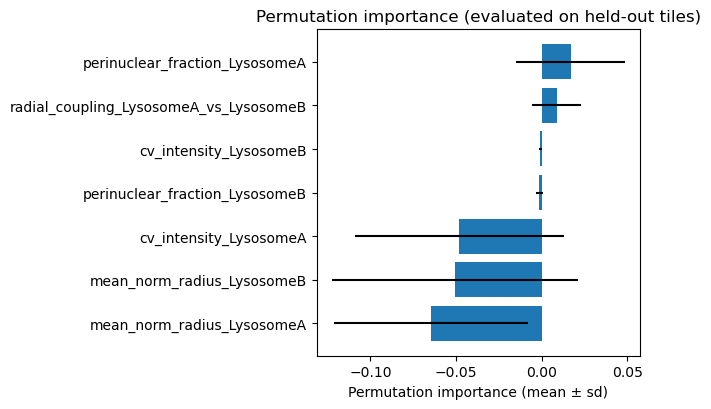

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\03_rf_importance_permutation_cvmean.png


E:\anaconda\envs\bioimage\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


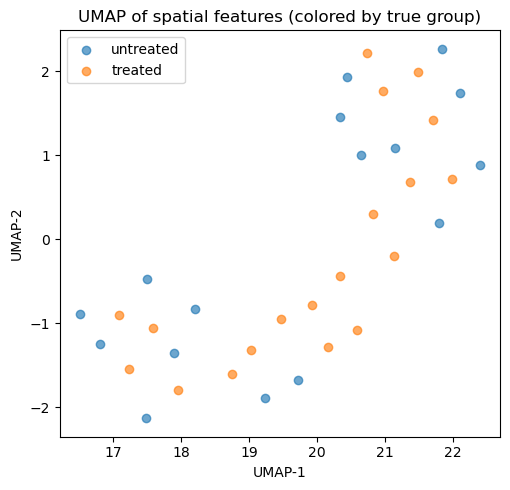

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\03_umap_true_group.png


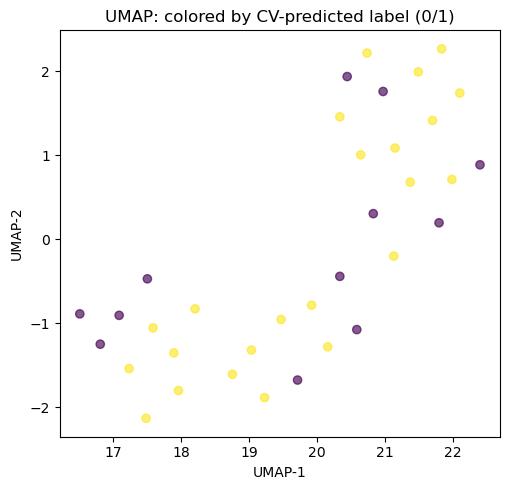

Saved: C:\Users\yixiao Zhou\Desktop\image-based-phenotyping-pipeline\figures\03_umap_cv_predicted.png


In [4]:
# =========================================================
# Notebook3 (FINAL, unified)
# Title : Cell-level spatial phenotype learning
# Goal  : Let ML learn treated vs untreated from features only
# Design:
#   - No label leakage (group not in X)
#   - StratifiedGroupKFold by tile
#   - Out-of-fold confusion matrix
#   - CV-consistent feature importance
#   - UMAP / PCA for visualization only
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, balanced_accuracy_score,
    f1_score, roc_auc_score
)
from sklearn.inspection import permutation_importance

# =========================================================
# 1) Load data
# =========================================================
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data" / "toy_data" / "metadata"
FIG_DIR  = PROJECT_ROOT / "figures"
FIG_DIR.mkdir(exist_ok=True)

csv_path = DATA_DIR / "toy_cell_spatial_features__LysosomeA_vs_LysosomeB.csv"
df = pd.read_csv(csv_path)

print("Loaded:", csv_path)
print("Cells:", len(df))
print("Groups:", df["group"].value_counts().to_dict())
print("Tiles :", df["tile"].nunique())

# optional: restrict to mono/multi only
df = df[df["cell_class"].isin(["mono", "multi"])].reset_index(drop=True)

# =========================================================
# 2) Define X, y, groups (NO leakage)
# =========================================================
FEATURE_COLS = [
    "mean_norm_radius_LysosomeA",
    "mean_norm_radius_LysosomeB",
    "perinuclear_fraction_LysosomeA",
    "perinuclear_fraction_LysosomeB",
    "cv_intensity_LysosomeA",
    "cv_intensity_LysosomeB",
    "radial_coupling_LysosomeA_vs_LysosomeB",
]

X = df[FEATURE_COLS].astype(np.float32).values
y = df["group"].map({"untreated": 0, "treated": 1}).values
groups = df["tile"].astype(str).values

print("X shape:", X.shape)
print("y distribution:", dict(zip(*np.unique(y, return_counts=True))))
print("Leakage check:", set(FEATURE_COLS) & {"group", "tile"})

# =========================================================
# 3) Model
# =========================================================
rf = RandomForestClassifier(
    n_estimators=600,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# =========================================================
# 4) Stratified group CV (tile-aware)
# =========================================================
N_SPLITS = 3   # 12 tiles → 3 folds is stable
cv = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

y_true_all, y_pred_all, y_prob_all = [], [], []
fold_metrics = []

for fold, (tr, te) in enumerate(cv.split(X, y, groups=groups), start=1):
    rf.fit(X[tr], y[tr])

    ypred = rf.predict(X[te])
    yprob = rf.predict_proba(X[te])[:, 1]

    y_true_all.append(y[te])
    y_pred_all.append(ypred)
    y_prob_all.append(yprob)

    acc  = accuracy_score(y[te], ypred)
    bacc = balanced_accuracy_score(y[te], ypred)
    f1   = f1_score(y[te], ypred)
    auc  = roc_auc_score(y[te], yprob) if np.unique(y[te]).size == 2 else np.nan

    fold_metrics.append(dict(fold=fold, acc=acc, bacc=bacc, f1=f1, auc=auc))
    print(f"[Fold {fold}] acc={acc:.3f}  bacc={bacc:.3f}  f1={f1:.3f}  auc={auc if np.isfinite(auc) else 'nan'}")

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)
y_prob_all = np.concatenate(y_prob_all)

m = pd.DataFrame(fold_metrics)
print("\nCV metrics (mean ± sd):")
print(m.drop(columns=["fold"]).agg(["mean", "std"]).T)

# =========================================================
# 5) Confusion matrix (out-of-fold)
# =========================================================
cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["untreated", "treated"])

plt.figure(figsize=(4.8, 4.2))
disp.plot(values_format="d", ax=plt.gca(), colorbar=False)
plt.title("Confusion matrix (StratifiedGroupKFold, out-of-fold)")
plt.tight_layout()

out_cm = FIG_DIR / "03_confusion_treated_vs_untreated.png"
plt.savefig(out_cm, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_cm.resolve())

# =========================================================
# 6) Feature importance (CV-consistent)
# =========================================================
# --- 6.1 Gini importance: mean ± sd across folds
gini_mat = []
for tr, te in cv.split(X, y, groups=groups):
    rf.fit(X[tr], y[tr])
    gini_mat.append(rf.feature_importances_)

gini_mat = np.vstack(gini_mat)
gini_df = pd.DataFrame({
    "feature": FEATURE_COLS,
    "gini_mean": gini_mat.mean(axis=0),
    "gini_sd": gini_mat.std(axis=0)
}).sort_values("gini_mean", ascending=True)

plt.figure(figsize=(6.6, 4.2))
plt.barh(gini_df["feature"], gini_df["gini_mean"], xerr=gini_df["gini_sd"])
plt.xlabel("Gini importance (mean ± sd)")
plt.title("RF feature importance (CV-consistent)")
plt.tight_layout()

out_gini = FIG_DIR / "03_rf_importance_gini_cvmean.png"
plt.savefig(out_gini, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_gini.resolve())

# --- 6.2 Permutation importance: fold-mean on test tiles
perm_mat = []
for tr, te in cv.split(X, y, groups=groups):
    rf.fit(X[tr], y[tr])
    perm = permutation_importance(
        rf, X[te], y[te],
        n_repeats=30, random_state=42, n_jobs=-1
    )
    perm_mat.append(perm.importances_mean)

perm_mat = np.vstack(perm_mat)
perm_df = pd.DataFrame({
    "feature": FEATURE_COLS,
    "perm_mean": perm_mat.mean(axis=0),
    "perm_sd": perm_mat.std(axis=0)
}).sort_values("perm_mean", ascending=True)

plt.figure(figsize=(6.6, 4.2))
plt.barh(perm_df["feature"], perm_df["perm_mean"], xerr=perm_df["perm_sd"])
plt.xlabel("Permutation importance (mean ± sd)")
plt.title("Permutation importance (evaluated on held-out tiles)")
plt.tight_layout()

out_perm = FIG_DIR / "03_rf_importance_permutation_cvmean.png"
plt.savefig(out_perm, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_perm.resolve())

# =========================================================
# 7) UMAP (fallback to PCA if unavailable)
# =========================================================
try:
    import umap
    reducer = umap.UMAP(n_neighbors=25, min_dist=0.25, random_state=42)
    Z = reducer.fit_transform(X)
    emb = "UMAP"
except Exception:
    from sklearn.decomposition import PCA
    Z = PCA(n_components=2, random_state=42).fit_transform(X)
    emb = "PCA"

plt.figure(figsize=(5.2, 5.0))
for lab, name in [(0, "untreated"), (1, "treated")]:
    plt.scatter(Z[y == lab, 0], Z[y == lab, 1], alpha=0.65, label=name)
plt.xlabel(f"{emb}-1")
plt.ylabel(f"{emb}-2")
plt.title(f"{emb} of spatial features (colored by true group)")
plt.legend()
plt.tight_layout()

out_emb = FIG_DIR / f"03_{emb.lower()}_true_group.png"
plt.savefig(out_emb, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_emb.resolve())

# =========================================================
# 8) UMAP / PCA colored by CV-predicted label
# =========================================================
plt.figure(figsize=(5.2, 5.0))
plt.scatter(Z[:, 0], Z[:, 1], c=y_pred_all, alpha=0.65)
plt.xlabel(f"{emb}-1")
plt.ylabel(f"{emb}-2")
plt.title(f"{emb}: colored by CV-predicted label (0/1)")
plt.tight_layout()

out_emb_pred = FIG_DIR / f"03_{emb.lower()}_cv_predicted.png"
plt.savefig(out_emb_pred, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_emb_pred.resolve())
